In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-colorization-dataset/data/test_color/image5500.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5639.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5275.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5321.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5354.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5000.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5226.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5267.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5040.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5148.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5550.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5323.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5342.jpg
/kaggle/input/image-colorization-dataset/data/test_color/image5157.jpg
/kaggl

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import img_to_array ,load_img
from glob import glob
import shutil
import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import BinaryCrossentropy


2024-08-20 13:12:10.269964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 13:12:10.270072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 13:12:10.402195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import load_img
from skimage.io import imread

In [4]:
def dataset(path):
    path_list=[]
    for files in os.listdir(path):
        if files.endswith('.jpg'):
            img_path=os.path.join(path,files)
            path_list.append(img_path)
            
    return path_list
            

In [5]:
path_train_color='/kaggle/input/image-colorization-dataset/data/train_color'
path_train_gray='/kaggle/input/image-colorization-dataset/data/train_black'
path_test_gray='/kaggle/input/image-colorization-dataset/data/test_black'

In [6]:
train_color_list=dataset(path_train_color)
train_gray_list=dataset(path_train_gray)
test_gray_list=dataset(path_train_gray)

## Data Preprocessing

1- extract the path of images to a list
   -> train color photo image path
   
   -> train gray photo image path
   
   -> test color photo image path
   
   -> test grey photo image path
 
 
 2- read the images 
 
 3- standarize the images to (-1:1)
 
 4- creating a tensorflow dataset
 

In [7]:
print(f'colored training samples :-> {len(train_color_list)}  gray training samples :-> {len(train_gray_list)}')

colored training samples :-> 5000  gray training samples :-> 5000


In [8]:
image=imread(train_color_list[0])
image.shape

(400, 400, 3)

In [9]:
shape=256
re1=tf.cast(image,tf.uint8)
#re2=tf.cast(tf.image.resize(re1,(shape,shape),tf.float32))
#re2.shape

In [10]:
def preprocessing(greyscale_img_path,colored_img_path,shape):
    
    'Preprocessing for greyscale images'
    # using tf.io.read_file and then use tf.image.decode_image
    
    grey_img=tf.io.read_file(greyscale_img_path)
    
    #decode the image to a tensor
    grey_img=tf.image.decode_image(grey_img,channels=1)
    
    ## we have to manually set the shape of image to :-> (None,None,channel)
    grey_img.set_shape([None,None,1])
    
    #Resize
    grey_img=tf.image.resize(grey_img,(shape,shape))
    grey_img=tf.cast(grey_img,tf.float32)
    
    grey_img=(grey_img/127.5) -1 
    
    
    'Preprocessing for colored images'
    # using tf.io.read_file and then use tf.image.decode_image
    
    color_img=tf.io.read_file(colored_img_path)
    
    #decode the image to a tensor
    color_img=tf.image.decode_image(color_img,channels=3)
    
    ## we have to manually set the shape of image to :-> (None,None,channel)
    color_img.set_shape([None,None,3])
    
    #Resize
    color_img=tf.image.resize(color_img,(shape,shape))
    color_img=tf.cast(color_img,tf.float32)
    
    color_img=(color_img/127.5) -1 
    
    
    return grey_img,color_img


    
    

def create_dataset(grey_path_list,color_path_list,shape,batch_size=16,shuffle=True):
    
    ## create a dataset using image path list to do this use from_tensor_slices
    dataset=tf.data.Dataset.from_tensor_slices((grey_path_list,color_path_list))
    
    ## apply the preprocessing function to the dataset
    
    dataset=dataset.map(lambda greyscale_img_path,colored_img_path : preprocessing(greyscale_img_path,colored_img_path,shape),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Batch the dataset
    
    dataset=dataset.batch(batch_size)
    
    ## Prefetch for better performance
    
    dataset=dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset
    
    
    
    

In [11]:

batch_size=32
shape=256
train_dataset=create_dataset(train_gray_list,train_color_list,shape=shape,batch_size=batch_size)

In [12]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [13]:
grayscale_img, color_img = next(iter(train_dataset))

# Print the shapes
print(f'Grayscale Image Shape: {grayscale_img.shape}')
print(f'Color Image Shape: {color_img.shape}')

Grayscale Image Shape: (32, 256, 256, 1)
Color Image Shape: (32, 256, 256, 3)


In [14]:
## making discriminator model for the cgan architecture
    
def discriminator():
    input_img_source=Input(shape=(size,size,1))
    input_img_target=Input(shape=(size,size,3))

    init=RandomNormal(stddev=0.02)

    merged=Concatenate()([input_img_source,input_img_target])

    x=Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(merged)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)


    x=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)

         ## second output layer
    


        #output layer

    output=Conv2D(1,(4,4),padding='same',kernel_initializer=init,activation='sigmoid')(x)

    model=Model([input_img_source,input_img_target],output)

    opt=Adam(learning_rate=0.0002,beta_1=0.5)

    model.compile(loss='binary_crossentropy',optimizer=opt)

    return model
        
    
    
    

Making the GAN model first
1-Make Discriminator

2-Make generator

2-Make GAN

In [15]:
size=256
d_model=discriminator()
d_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 4)                │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,160 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16, 1) │      8,193 │ leaky_re_lu_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,769,345 (10.56 MB)

 Trainable params: 2,767,553 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
## Generator Architecture

def encoder(layer_in,n_filters,batchnorm=True):
    init=RandomNormal(stddev=0.02)
    ## adding downsampling layer
    
    x=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    ## conditionally add batchnormalization
    if batchnorm:
        x=BatchNormalization()(x,training=True)
        
    x=LeakyReLU(alpha=0.2)(x)
    
    return x


def decoder(layer_in,skip,n_filters,dropout=True):
    
    init=RandomNormal(stddev=0.02)
    
    # adding upsampling layer
    
    x=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    x=BatchNormalization()(x)
    
    # add conditional dropout layer
    if dropout:
        x=Dropout(0.5)(x)
        
    # merge with skip connection
    x=Concatenate()([x,skip])
    x=ReLU()(x)
    
    return x
    

In [17]:
def generator():
    init=RandomNormal(stddev=0.02)
    input_layer_source=Input(shape=(size,size,1))
    
    # DownSampling layer
    
    
    e1=encoder(input_layer_source,64,batchnorm=False)
    e2=encoder(e1,128)
    e3=encoder(e2,256)
    e4=encoder(e3,512)
    e5=encoder(e4,512)
    e6=encoder(e5,512)
    e7=encoder(e6,512)
    
    
    ## simple bridge layer
    
    x=Conv2D(512,(4,4),strides=(2,2),kernel_initializer=init,padding='same',activation='relu')(e7)
    
    ## Upsampling Layer
    
    u1=decoder(x,e7,512)
    u2=decoder(u1,e6,512)
    u3=decoder(u2,e5,512)
    u4=decoder(u3,e4,512,dropout=False)
    u5=decoder(u4,e3,256,dropout=False)
    u6=decoder(u5,e2,128,dropout=False)
    u7=decoder(u6,e1,64,dropout=False)
    
    ## output layer
    
    output=Conv2DTranspose(3,(4,4),strides=(2,2),padding='same',kernel_initializer=init,activation='tanh')(u7)
    
    model=Model(input_layer_source,output)
    return model
    
    
    
    
    

In [18]:
size=256
g_model=generator()
g_model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      1,088 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    524,544 │ leaky_re_lu_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_6[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 54,427,267 (207.62 MB)

 Trainable params: 54,417,411 (207.59 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [19]:
loss_object=BinaryCrossentropy(from_logits=True)


    
optim_dis=Adam(0.001,beta_1=0.9,beta_2=0.999)
optim_gen=Adam(0.001,beta_1=0.9,beta_2=0.999)

LAMBDA=100
SSIM_lambda=0.5

def generator_loss(dis_gene_output,gen_output,target):
    gan_loss=loss_object(tf.ones_like(dis_gene_output),dis_gene_output)
    
    # mean absolute error
    l1_loss=tf.reduce_mean(tf.abs(target-gen_output))
    
    ## also include ssim loss
    ssim_loss=(1-tf.reduce_mean(tf.image.ssim(gen_output,target,max_val=1.0)))
    
    total_gan_loss=gan_loss + LAMBDA*l1_loss + SSIM_lambda*ssim_loss
    return total_gan_loss,l1_loss,gan_loss,ssim_loss

def discriminator_loss(dis_real_output,dis_gene_output):
    real_loss=loss_object(tf.ones_like(dis_real_output),dis_real_output) ## class 1 loss
    gen_loss=loss_object(tf.zeros_like(dis_gene_output),dis_gene_output)  ## class 0 loss
    total_loss=real_loss+gen_loss
    
    return total_loss

In [20]:
def training_step(input_image, target,epochs):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        gen_output = g_model(input_image, training=True)
        dis_real_output = d_model([input_image, target], training=True)
        dis_gene_output = d_model([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss,ssim_loss = generator_loss(dis_gene_output, gen_output, target)
        dis_loss = discriminator_loss(dis_real_output, dis_gene_output)
    
    generator_gradients = gen_tape.gradient(gen_total_loss, g_model.trainable_variables)
    discriminator_gradients = dis_tape.gradient(dis_loss, d_model.trainable_variables)
    
    optim_gen.apply_gradients(zip(generator_gradients, g_model.trainable_variables))
    optim_dis.apply_gradients(zip(discriminator_gradients, d_model.trainable_variables))
    
    return gen_total_loss,gen_gan_loss,gen_l1_loss,dis_loss,ssim_loss

1- define a custom fit function
2- 

In [21]:
def fit(training_dataset,epochs):
    for epoch in range(epochs):
        print(f'Epoch :- {epoch+1}/{epochs}')
     
        for n,(grayscale_img, color_img) in training_dataset.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, dis_loss,ssim_loss=training_step(grayscale_img, color_img,epochs)
            
        
            if n % 100 == 0:
                    print(f"Step {n}:")
                    print(f"  Generator Total Loss: {gen_total_loss.numpy():.4f}")
                    print(f"  Generator GAN Loss: {gen_gan_loss.numpy():.4f}")
                    print(f"  Generator L1 Loss: {gen_l1_loss.numpy():.4f}")
                    print(f"  Discriminator Loss: {dis_loss.numpy():.4f}")
                    print(f"  Discriminator Loss: {ssim_loss.numpy():.4f}")
        
    

In [22]:
fit(train_dataset,epochs=100)
    

Epoch :- 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Step 0:
  Generator Total Loss: 52.8472
  Generator GAN Loss: 0.5160
  Generator L1 Loss: 0.7457
  Discriminator Loss: 1.7276
  Discriminator Loss: 0.9994
Step 100:
  Generator Total Loss: 14.1153
  Generator GAN Loss: 0.1309
  Generator L1 Loss: 0.8124
  Discriminator Loss: 1.2434
  Discriminator Loss: 0.4299
Epoch :- 2/100
Step 0:
  Generator Total Loss: 15.1664
  Generator GAN Loss: 0.1372
  Generator L1 Loss: 1.2321
  Discriminator Loss: 0.7885
  Discriminator Loss: 0.4208
Step 100:
  Generator Total Loss: 14.9785
  Generator GAN Loss: 0.1260
  Generator L1 Loss: 2.1893
  Discriminator Loss: 0.6289
  Discriminator Loss: 0.3764
Epoch :- 3/100
Step 0:
  Generator Total Loss: 14.8212
  Generator GAN Loss: 0.1346
  Generator L1 Loss: 1.1636
  Discriminator Loss: 0.9602
  Discriminator Loss: 0.3943
Step 100:
  Generator Total Loss: 13.3172
  Generator GAN Loss: 0.1233
  Generator L1 Loss: 0.8112
  Discriminator Loss: 1.4220
  Discriminator Loss: 0.3485
Epoch :- 4/100
Step 0:
  Generator

In [23]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

# Load the images
test_image = load_img('/kaggle/input/image-colorization-dataset/data/test_black/image5001.jpg', color_mode='grayscale', target_size=(256, 256))
test_color = load_img('/kaggle/input/image-colorization-dataset/data/test_color/image5001.jpg', target_size=(256, 256))

# Convert the images to arrays
test_image_array = img_to_array(test_image)  # This will give shape (256, 256, 1)
test_color_array = img_to_array(test_color)  # This will give shape (256, 256, 3)

# Rescale the pixel values to [-1, 1]
test_image_array = (test_image_array / 127.5) - 1
test_color_array = (test_color_array / 127.5) - 1

# Convert arrays to tensors
test_image_tensor = tf.convert_to_tensor(test_image_array, dtype=tf.float32)
test_color_tensor = tf.convert_to_tensor(test_color_array, dtype=tf.float32)

# Add batch dimension (to make it a batch of one image)
test_image_tensor = tf.expand_dims(test_image_tensor, axis=0)
test_color_tensor = tf.expand_dims(test_color_tensor, axis=0)



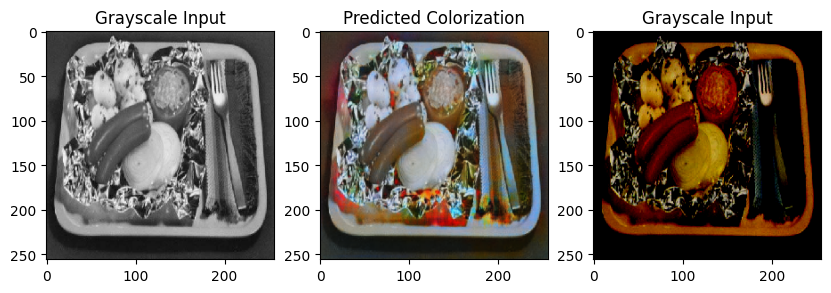

In [24]:
# Generate prediction
prediction=g_model(test_image_tensor ,training=False)

# Denormalize the predicted image to the range [0, 255]
predicted_image = (prediction + 1) * 127.5
predicted_image = tf.cast(predicted_image, tf.uint8)

# Remove the batch dimension for visualization
predicted_image = tf.squeeze(predicted_image, axis=0)

# Display the grayscale input and the predicted colorization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Grayscale Input")
plt.imshow(tf.squeeze(test_image_tensor, axis=0), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Predicted Colorization")
plt.imshow(predicted_image)

plt.subplot(1, 3, 3)
plt.title("Grayscale Input")
plt.imshow(tf.squeeze(test_color_tensor,axis=0))



plt.show()